In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
import anndata
from functools import partial
from copy import deepcopy

from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scanpy as sc
import time
import os
from scipy import sparse

from utils.explanation_utils import explanation_hook, get_explanation

torch.cuda.set_device(2)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"

# check available files
# !ls ../real_data

torch.autograd.set_detect_anomaly(True)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
sc.__version__

'1.9.3'

In [3]:
# select dataset to analyze
# dataset = "10X_PBMC"

# filtered_matrix_h5 = f"{path}real_data/{dataset}.h5"
# filtered_feature_bc_matrix = get_matrix_from_h5(filtered_matrix_h5)

# dataset = "pancreas"
# adata = sc.read('data/%s.h5ad' % (dataset), backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

adata = sc.read_loom("seurat_pbmc.loom")

# for getting gene name for the seurat data
adata_2 = sc.read_h5ad("scVI_pbmc.h5ad")

# adata = sc.read_h5ad('data/%s.h5ad' % (dataset), backed = 'r')
# adata = sc.read_h5ad('data/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad')
batch_str = "batch"

adata

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'CellType', 'Method', 'batch', 'nCount_RNA', 'nFeature_RNA', 'orig.ident'

In [4]:
adata.var.index = adata_2.var.index

In [5]:
# adata.var

In [6]:
adata.X.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.017542  ,  0.        , ..., -0.08353431,
         0.        , -0.02943087],
       [ 0.        ,  0.        , -0.02108115, ..., -0.09182554,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.13054192,
         0.        ,  0.        ]], dtype=float32)

In [7]:
# output_results = adata.X

max_val = np.amax(adata.X.toarray())
min_val = np.amin(adata.X.toarray())

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  8.408169
Lower bound of the gene expression:  -3.2816553


In [8]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=150, frameon=False, figsize=(3, 3), facecolor='white')

# adata.X = sc.pp.normalize_per_cell(adata.X, copy = True, counts_per_cell_after=1e4, min_counts=0)
# adata.X = sc.pp.log1p(adata.X)
# # observer batch effect
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['Batch', 'celltype'],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [9]:
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=["Group"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [10]:
# sc.pl.umap(adata, color=['tissue'],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [11]:
# G_AB.eval()
# with torch.no_grad():
#     imgs = Variable(FloatTensor(scd.X))
# #         select batch for anchoring

#     labels_ = [0.0]

#     for each in range(c_dim - 1):
#         labels_.append(0.0)

#     labels_ = np.array(labels_)

#     labels_ = np.tile(labels_, (scd.X.shape[0], 1))

#     labels = Variable(FloatTensor(labels_))

#     labels[:, anchor_index] = 1.0

# #     labels = Variable(FloatTensor(scd.labels))

#     groups = Variable(FloatTensor(scd.groups))

#     static_sample = G_AB(imgs, labels)
#     fake_data = static_sample.cpu().detach().numpy()  # pseudo-cell expression vector
    
# output_results = fake_data

In [12]:
output_results = adata.X.toarray()

In [13]:
from sklearn.decomposition import PCA

adata.obsm["X_latent"] = output_results.copy()

# output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# output_results_log_norm = sc.pp.log1p(output_results_norm)
# output_results_scaled = sc.pp.scale(output_results_log_norm)
# output_results_scaled = sc.pp.scale(output_results, copy = True)

# adata.obsm["X_latent_norm"] = output_results_log_norm
# adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

pca = PCA(n_components = 50, random_state = 8)

# pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

pca.fit(output_results)

X_pca = pca.transform(output_results)

adata.obsm["X_pca"] = X_pca

In [14]:
output_results.shape

(15476, 10000)

In [15]:
adata.obs["batch"] = [str(each) for each in list(adata.obs["batch"].values)]

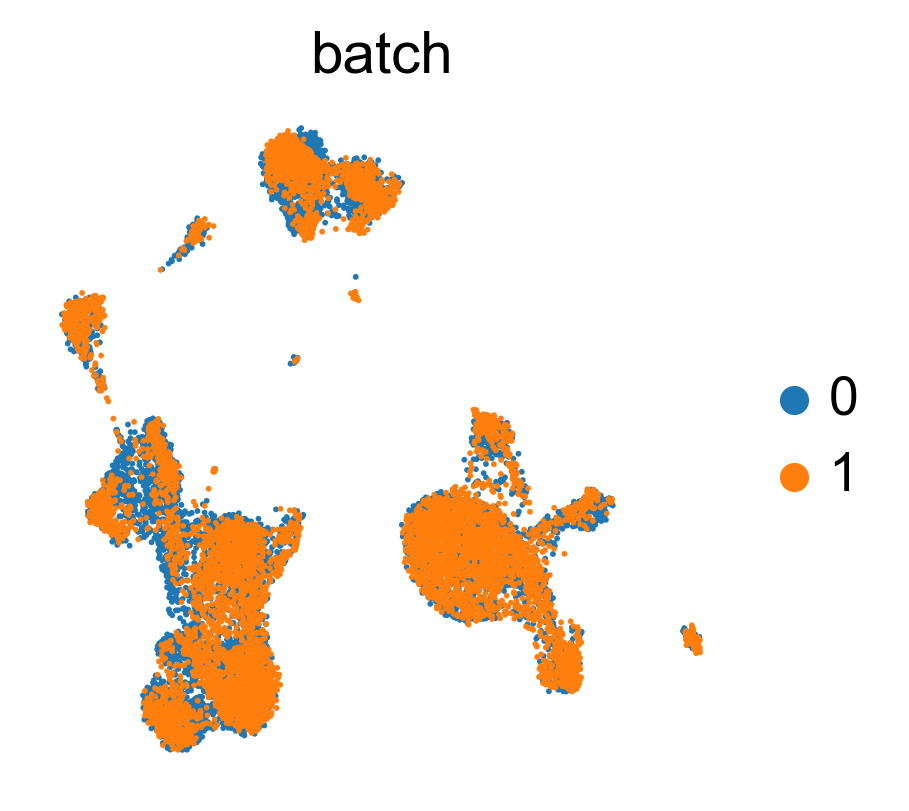

In [16]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch'],
           palette=sc.pl.palettes.vega_20_scanpy)


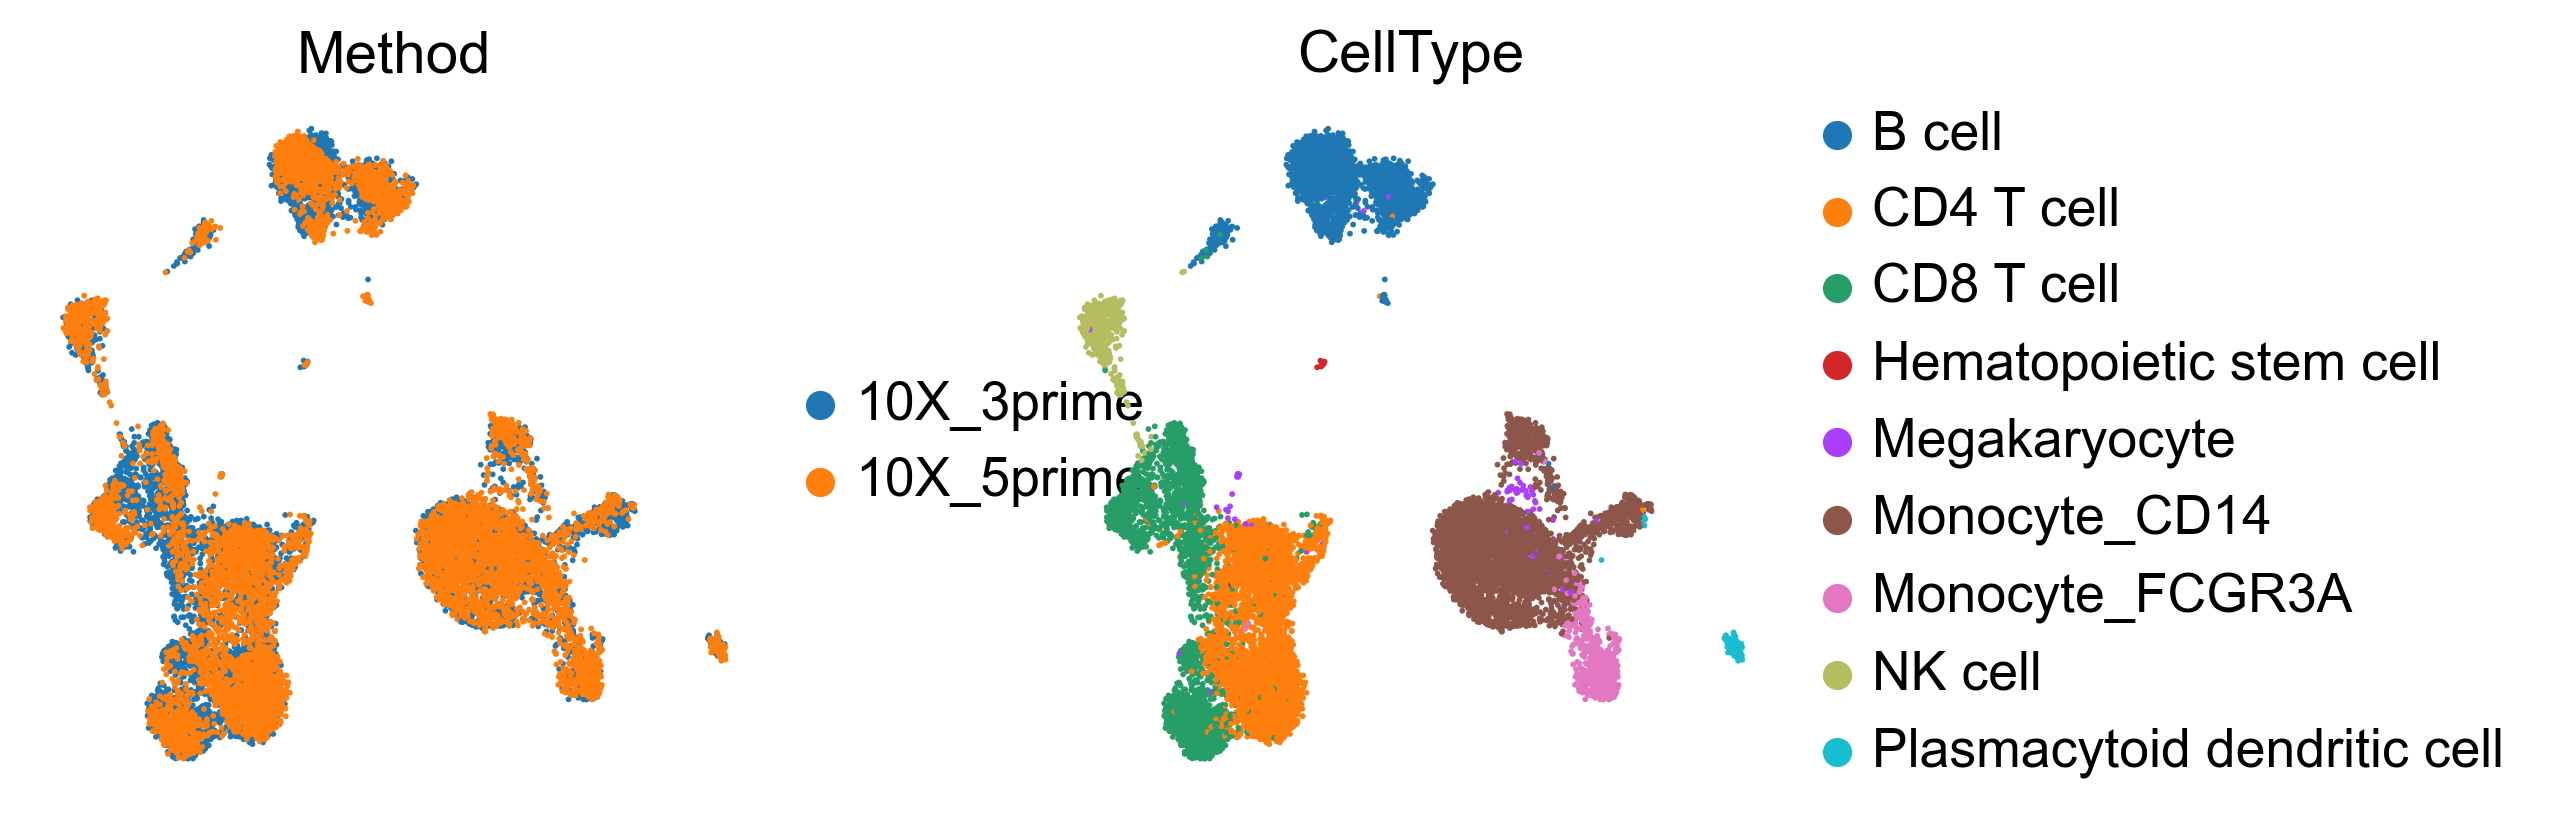

In [17]:
# adata.obsm["X_latent"] = output_results

# sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# sc.external.pp.bbknn(adata, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)
sc.pl.umap(adata, color=["Method","CellType"],
           palette=sc.pl.palettes.vega_20_scanpy)

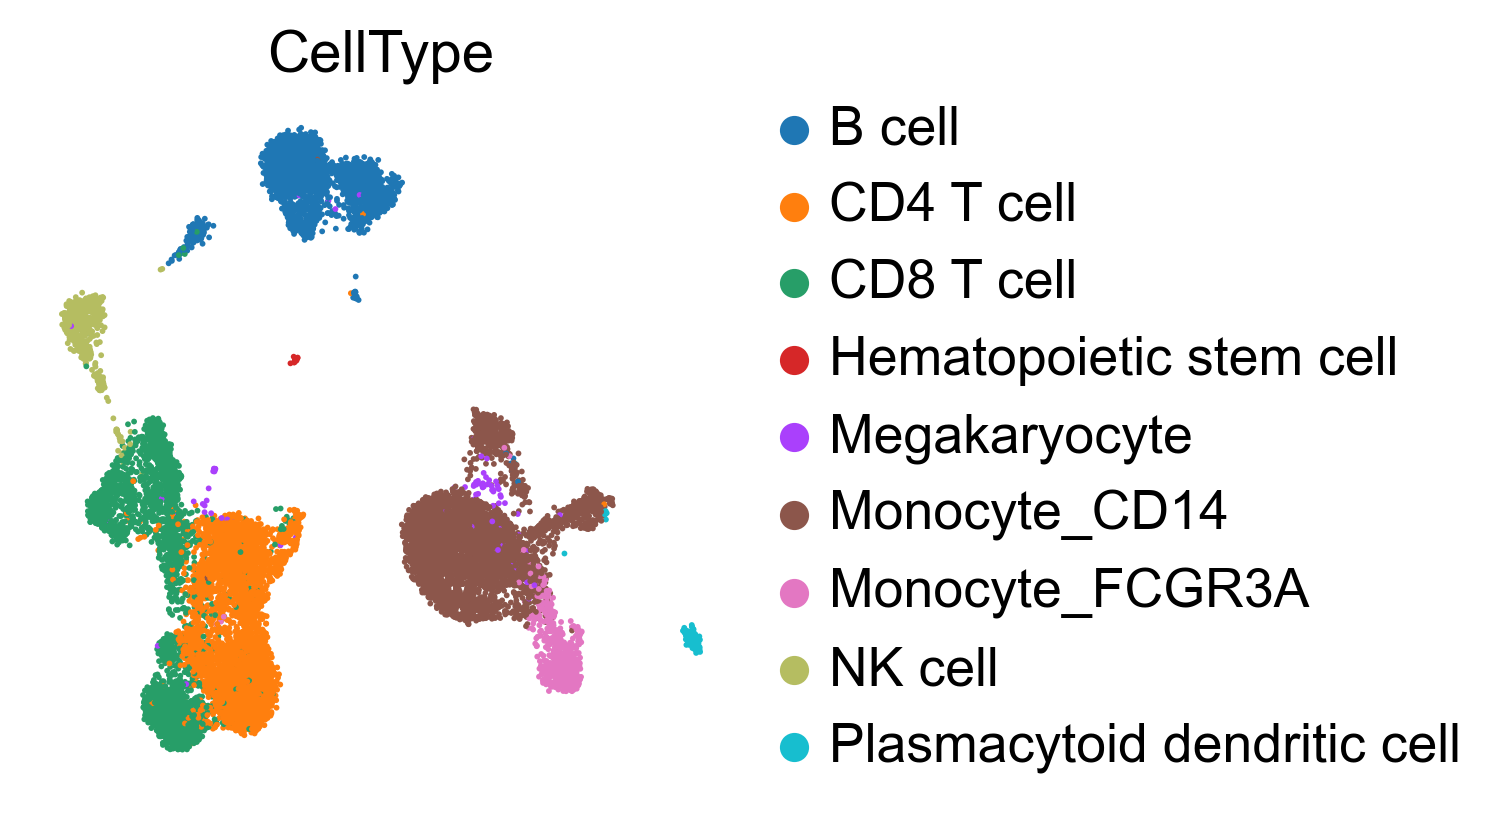

In [18]:
sc.pl.umap(adata, color=["CellType"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [19]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

In [20]:
resolutions = None

if resolutions is None:
    n = 20
    resolutions = [2 * x / n for x in range(1, n + 1)]

score_max = 0
res_max = resolutions[0]
clustering = None
score_all = []
use_rep = "X_pca"
cluster_key = "louvain"
label_key = "CellType"

try:
    adata.uns["neighbors"]
except KeyError:
    if verbose:
        print("computing neighbours for opt_cluster")
    sc.pp.neighbors(adata, use_rep=use_rep)

In [21]:
for res in resolutions:
    sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
    score = ari(adata, label_key, cluster_key)
    score_all.append(score)
    if score_max < score:
        score_max = score
        res_max = res
        clustering = adata.obs[cluster_key]

In [22]:
score_max

0.6591214883933245

In [23]:
adata

AnnData object with n_obs × n_vars = 15476 × 10000
    obs: 'CellType', 'Method', 'batch', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'louvain'
    uns: 'neighbors', 'umap', 'batch_colors', 'Method_colors', 'CellType_colors', 'louvain'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [24]:
adata.var = adata_2.var

In [25]:
adata.write_h5ad("seurat_pbmc.h5ad")

In [26]:
adata.var

,gene_name,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
5,RP11-34P13.14,3,True,5579.0,0.000194,0.000194,0.487263,1
7,FO538757.3,13,True,2720.0,0.001163,0.001937,1.273583,2
14,RP5-857K21.4,11,True,7225.5,0.000711,0.000710,0.959566,2
19,FAM87B,6,True,5612.0,0.000388,0.000388,0.978018,2
21,FAM41C,286,True,4401.0,0.019062,0.019863,0.968758,1
...,...,...,...,...,...,...,...,...
33676,AC145212.4,22,True,7560.0,0.001422,0.001420,0.939044,1
33683,AC007325.4,170,True,6744.0,0.011243,0.011634,0.955012,1
33688,AC004556.1,1115,True,5984.0,0.081158,0.101458,0.937072,1
33689,AC233755.2,19,True,464.0,0.002455,0.007231,1.251472,1


In [27]:
adata.obsm["X_latent"]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.017542  ,  0.        , ..., -0.08353431,
         0.        , -0.02943087],
       [ 0.        ,  0.        , -0.02108115, ..., -0.09182554,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.13054192,
         0.        ,  0.        ]], dtype=float32)

In [28]:
adata.X.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.017542  ,  0.        , ..., -0.08353431,
         0.        , -0.02943087],
       [ 0.        ,  0.        , -0.02108115, ..., -0.09182554,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.13054192,
         0.        ,  0.        ]], dtype=float32)

In [29]:
# clear GPUc
import torch
torch.cuda.empty_cache()